In [1]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os

In [3]:
# Load saved models and results
PLAYGROUND_DIR = "~/logs/EI_RLDM/decision_making"
models_dir = f"{PLAYGROUND_DIR}/saved_models"
results_dir = f"{PLAYGROUND_DIR}/saved_results"


n_output_classes = 2
n_hidden = 125

n_epochs = 600  # Adjust based on training epochs
batch_size = 200
n_seeds = 50
seeds = [i for i in range(n_seeds)]
grad_clip_list = [None]
rad_list = [1.2]
lr_list = [4e-4]
ei_ratio_list = [4]
para_comb = list(itertools.product(seeds, lr_list, grad_clip_list, rad_list, ei_ratio_list)) # 
(seed, _, _, rad, ei_ratio) = para_comb[0]
learning_rates = { "rnn": 6e-4,
    "colei": 6e-4,
    "danns": 2e-4
    }

grad_clips = { "rnn": 1,
    "colei": 1,
    "danns": 1
    }


# Initialize dictionaries to store losses
models = {
    "rnn": {}, 
    "colei": {},
    "danns": {}
}
models_output_vs_targets = {
    "rnn": {},
    "colei": {},
    "danns": {}
}
num_trials = 100
time_steps = 60

In [4]:
test_size = 100
valid_size = 100
num_batches = 1 #len(data_train) // batch_size
decision_threshold = 0.25
stimulus_onset = 10 
stimulus_duration = 21

In [ ]:
for model_type in models.keys():
    learning_rate = learning_rates[model_type]
    grad_clip = grad_clips[model_type]
    models[model_type] = {k: np.zeros((n_seeds, n_epochs)) for k in ["test_loss", "train_loss", "outputs_test", "targets_test", "accuracy", "valid_trial_count"]}
    models_output_vs_targets[model_type] = {k: np.zeros((n_seeds, n_epochs, num_trials, time_steps, n_output_classes)) for k in ["outputs_test", "targets_test"]}
    models[model_type]["prob_sigm"] = np.zeros((n_seeds, n_epochs, test_size))
    models[model_type]["valid_trials"] = np.zeros((n_seeds, n_epochs, test_size))
    
    for seed in seeds:
        if model_type == "colei":
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{learning_rate}_GC{grad_clip}_adam.npz"
        else:
            results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{learning_rate}_GC{grad_clip}_adam.npz"
        if os.path.exists(results_path):
            dict_data = np.load(results_path)
            # dict_data = dict(data)
            models[model_type]["train_loss"][seed, :] = dict_data["train_loss"][:n_epochs]
            models[model_type]["test_loss"][seed, :] = dict_data["test_loss"][:n_epochs]
            models[model_type]["accuracy"][seed, :] = dict_data["accuracy"][:n_epochs]
            models[model_type]["valid_trial_count"][seed, :] = dict_data["valid_trial_count"][:n_epochs]
            try:
                models[model_type]["valid_trials"][seed, :] = dict_data["valid_trials"][:n_epochs]
                models[model_type]["prob_sigm"][seed, :] = dict_data["prob_sigm"][:n_epochs]
            except Exception as e:
                print(e, results_path)
 
        else:
            print(f"Warning: Missing file {results_path}")

In [6]:
# Compute mean and standard deviation across seeds
train_loss_mean = {model: np.mean(models[model]["train_loss"], axis=0) for model in models}
train_loss_std = {model: np.std(models[model]["train_loss"], axis=0) for model in models}
test_loss_mean = {model: np.mean(models[model]["test_loss"], axis=0) for model in models}
test_loss_std = {model: np.std(models[model]["test_loss"], axis=0) for model in models}
accuracy_mean = {model: np.mean(models[model]["accuracy"], axis=0) for model in models}
accuracy_std = {model: np.std(models[model]["accuracy"], axis=0) for model in models}
valid_trials_mean = {model: np.mean(models[model]["valid_trial_count"], axis=0) for model in models}
valid_trials_std = {model: np.std(models[model]["valid_trial_count"], axis=0) for model in models}

# outputs_test_0 = {model: models_output_vs_targets[model]["outputs_test"][0] for model in models}
# targets_test_0 = {model: models_output_vs_targets[model]["targets_test"][0] for model in models}

In [7]:
prob_sigm_mean = {model: np.mean(models[model]["prob_sigm"], axis=0) for model in models}
prob_sigm_std = {model: np.std(models[model]["prob_sigm"], axis=0) for model in models}
valid_trials_mean = {model: np.mean(models[model]["valid_trials"], axis=0) for model in models}
valid_trials_std = {model: np.std(models[model]["valid_trials"], axis=0) for model in models}


In [9]:
test_size = 100
valid_size = 100
num_batches = 1 #len(data_train) // batch_size
decision_threshold = 0.25
stimulus_onset = 10 
stimulus_duration = 21

# ## Set Hyperparameters
input_features = 2
n_output_classes = 2
n_hidden = 125
device = 'cpu'

dataset_path = f"{PLAYGROUND_DIR}/datasets/decision_making_data.npz"
data = np.load(dataset_path)
inputs_series = data['inputs_series']
targets_series = data['targets_series']
coherence_series = data['coherence_series']
mask_series = data['mask_series']


In [ ]:
# Load Dataset
import torch
data_train = inputs_series[:-valid_size-test_size]
targets_train = targets_series[:-valid_size-test_size]
masks_train = mask_series[:-valid_size-test_size]
coherence_train = coherence_series[:-valid_size-test_size]

data_valid = torch.from_numpy(inputs_series[-valid_size-test_size:-test_size]).float().to(device)
targets_valid = torch.from_numpy(targets_series[-valid_size-test_size:-test_size]).float().to(device)

data_test = torch.from_numpy(inputs_series[-test_size:]).float().to(device)
targets_test = torch.from_numpy(targets_series[-test_size:]).float().to(device)
coherence_test = coherence_series[-test_size:]

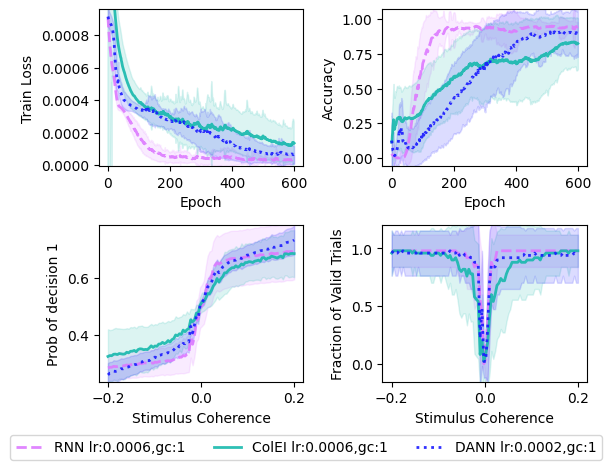

In [11]:
# Plot results
labels = {"rnn": "RNN",
          "colei": "ColEI",
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['--',  '-',':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]
fig, axes = plt.subplots(2, 2, figsize=(6, 4.5), squeeze=False)

### Train Loss ###
all_loss_values = []
for i, model_type in enumerate(models.keys()):
    loss_values = train_loss_mean[model_type]
    std_values = train_loss_std[model_type]
    loss_values = np.nan_to_num(loss_values, nan=0)
    std_values = np.nan_to_num(std_values, nan=0)

    all_loss_values.extend(loss_values - std_values)
    all_loss_values.extend(loss_values + std_values)

    axes[0, 0].plot(loss_values, lw=2, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i], linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 0].fill_between(range(n_epochs), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Train Loss")
# axes[0, 0].legend()

all_loss_values = np.nan_to_num(all_loss_values, nan=0)
y_min, y_max = np.percentile(all_loss_values, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)

# colormaps = [plt.cm.spring, plt.cm.summer, plt.cm.autumn, plt.cm.winter, plt.cm.cool]
# n_colors = 3
# colors = [colormaps[4](0.8)]
# colors.append([colormaps[3](v) for v in np.linspace(0., 0.7, n_colors)[::-1]][2])
# colors.append([colormaps[1](v) for v in np.linspace(0., 0.6, n_colors)[::-1]][2])
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]

#add685
### Accuracy ###
all_accuracy_values = []
for i, model_type in enumerate(models.keys()):
    acc_values = accuracy_mean[model_type]
    std_values = accuracy_std[model_type]

    all_accuracy_values.extend(acc_values - std_values)
    all_accuracy_values.extend(acc_values + std_values)

    axes[0, 1].plot(acc_values, color=colors[i], lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 1].fill_between(range(n_epochs), acc_values - std_values, acc_values + std_values, color=colors[i], alpha=0.15)

axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")
# axes[0, 1].legend()

y_min, y_max = np.percentile(all_accuracy_values, [1, 99])
axes[0, 1].set_ylim(y_min, y_max)


### Accuracy ###
all_probs = []
for i, model_type in enumerate(models.keys()):

    mean_probs = prob_sigm_mean[model_type][-1, :]
    std_probs = prob_sigm_std[model_type][-1, :]
    mean_probs = np.nan_to_num(mean_probs, nan=0)
    std_probs = np.nan_to_num(std_probs, nan=0)

    all_probs.extend(mean_probs - std_probs)
    all_probs.extend(mean_probs + std_probs)

    axes[1, 0].plot(coherence_test, mean_probs,  color=colors[i], linestyle=linestyles[i], lw=2, alpha=0.9, zorder=2)
    axes[1, 0].fill_between(coherence_test, mean_probs - std_probs, mean_probs + std_probs, color=colors[i], alpha=0.15)


axes[1, 0].set_xlabel("Stimulus Coherence")
axes[1, 0].set_ylabel("Prob of decision 1")
# axes[1, 0].legend()


all_probs = np.nan_to_num(all_probs, nan=0)
y_min, y_max = np.percentile(all_probs, [1, 99])
axes[1, 0].set_ylim(y_min, y_max)

all_valid_trials = []
for i, model_type in enumerate(models.keys()):

    mean_valid_trials = valid_trials_mean[model_type][-1, :]
    std_valid_trials = valid_trials_std[model_type][-1, :]
    mean_valid_trials = np.nan_to_num(mean_valid_trials, nan=0)
    std_valid_trials = np.nan_to_num(std_valid_trials, nan=0)

    all_valid_trials.extend(mean_valid_trials - std_valid_trials)
    all_valid_trials.extend(mean_valid_trials + std_valid_trials)

    axes[1, 1].plot(coherence_test, mean_valid_trials, color=colors[i], linestyle=linestyles[i],lw=2, alpha=0.9, zorder=2)
    axes[1, 1].fill_between(coherence_test, mean_valid_trials - std_valid_trials, mean_valid_trials + std_valid_trials, color=colors[i], alpha=0.15)


axes[1, 1].set_xlabel("Stimulus Coherence")
axes[1, 1].set_ylabel("Fraction of Valid Trials")
# axes[1, 1].legend()


all_valid_trials = np.nan_to_num(all_valid_trials, nan=0)
y_min, y_max = np.percentile(all_valid_trials, [1, 99])
axes[1, 1].set_ylim(y_min, y_max)

handles, labels = [], []
for ax in axes.flat:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.05))

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.show()

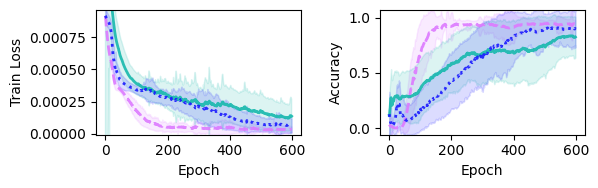

In [ ]:
# Plot results
labels = {"rnn": "RNN",
          "colei": "ColEI",
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['--',  '-',':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]
fig, axes = plt.subplots(1, 2, figsize=(6, 2), squeeze=False)

### Train Loss ###
all_loss_values = []
for i, model_type in enumerate(models.keys()):
    loss_values = train_loss_mean[model_type]
    std_values = train_loss_std[model_type]
    loss_values = np.nan_to_num(loss_values, nan=0)
    std_values = np.nan_to_num(std_values, nan=0)

    all_loss_values.extend(loss_values - std_values)
    all_loss_values.extend(loss_values + std_values)

    axes[0, 0].plot(loss_values, lw=2, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i], linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 0].fill_between(range(n_epochs), loss_values - std_values, loss_values + std_values, color=colors[i], alpha=0.15)

axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Train Loss")
# axes[0, 0].legend()

all_loss_values = np.nan_to_num(all_loss_values, nan=0)
y_min, y_max = np.percentile(all_loss_values, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)

# colormaps = [plt.cm.spring, plt.cm.summer, plt.cm.autumn, plt.cm.winter, plt.cm.cool]
# n_colors = 3
# colors = [colormaps[4](0.8)]
# colors.append([colormaps[3](v) for v in np.linspace(0., 0.7, n_colors)[::-1]][2])
# colors.append([colormaps[1](v) for v in np.linspace(0., 0.6, n_colors)[::-1]][2])
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]

#add685
### Accuracy ###
all_accuracy_values = []
for i, model_type in enumerate(models.keys()):
    acc_values = accuracy_mean[model_type]
    std_values = accuracy_std[model_type]

    all_accuracy_values.extend(acc_values - std_values)
    all_accuracy_values.extend(acc_values + std_values)

    axes[0, 1].plot(acc_values, color=colors[i], lw=2, linestyle=linestyles[i], alpha=0.9, zorder=2)
    axes[0, 1].fill_between(range(n_epochs), acc_values - std_values, acc_values + std_values, color=colors[i], alpha=0.15)

axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Accuracy")
# axes[0, 1].legend()

y_min, y_max = np.percentile(all_accuracy_values, [1, 99])
axes[0, 1].set_ylim(y_min, y_max)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.01, 1, 1])
plt.show()

In [ ]:
lr_gc_list = list(itertools.product([1e-3, 6e-4, 4e-4, 2e-4, 1e-4], [1, 5, 10]))
models_extended = {i: {"rnn": {}, "colei": {}, "danns": {}} for i, _ in enumerate(lr_gc_list)}
for i, (lr, gc)  in enumerate(lr_gc_list):
    for model_type in models_extended[i].keys():
        models_extended[i][model_type] = {k: np.zeros((n_seeds, n_epochs)) for k in ["test_loss", "train_loss", "accuracy", "valid_trial_count"]}

        for seed in seeds:
            if model_type == "colei":
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{lr}_GC{gc}_adam.npz"
            else:
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.npz"
            
            if os.path.exists(results_path):
                data = np.load(results_path)
                try:
                    models_extended[i][model_type]["train_loss"][seed, :] = data["train_loss"][:n_epochs]
                    models_extended[i][model_type]["test_loss"][seed, :] = data["test_loss"][:n_epochs]
                    models_extended[i][model_type]["accuracy"][seed, :] = data["accuracy"][:n_epochs]
                    models_extended[i][model_type]["valid_trial_count"][seed, :] = data["valid_trial_count"][:n_epochs]
                except Exception as e: 
                    print(e)
                    print(results_path)
            else:
                print(f"Warning: Missing file {results_path}")
accuracy_mean2 = {i: {model: np.mean(np.trapz(models_extended[i][model]["accuracy"], axis=-1), axis=0) for model in models_extended[i]} for i, (lr, gc) in enumerate(lr_gc_list)}
accuracy_std2 = {i: {model: np.std(np.trapz(models_extended[i][model]["accuracy"], axis=-1), axis=0) for model in models_extended[i]} for i, (lr, gc) in enumerate(lr_gc_list)}

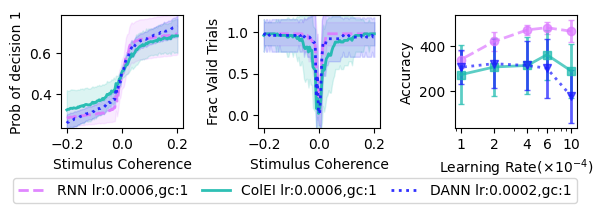

In [17]:
# Plot results
labels = {"rnn": "RNN",
          "colei": "ColEI",
          "danns": "DANN"
          }
COLORS = plt.get_cmap('Set1').colors
linestyles = ['--',  '-',':', '-.', '--', ':', '-.', (0, (5, 2))]
colors = [mpl.colors.rgb2hex(color[:3]) for color in COLORS]
colors = ["#dd7aff", "#17b9ad", "#1a1aff" ]
fig, axes = plt.subplots(1, 3, figsize=(6, 2), squeeze=False)

### Accuracy ###
all_probs = []
for i, model_type in enumerate(models.keys()):

    mean_probs = prob_sigm_mean[model_type][-1, :]
    std_probs = prob_sigm_std[model_type][-1, :]
    mean_probs = np.nan_to_num(mean_probs, nan=0)
    std_probs = np.nan_to_num(std_probs, nan=0)

    all_probs.extend(mean_probs - std_probs)
    all_probs.extend(mean_probs + std_probs)

    axes[0, 0].plot(coherence_test, mean_probs, label=f"{labels[model_type]} lr:{learning_rates[model_type]},gc:{grad_clips[model_type]}", color=colors[i], linestyle=linestyles[i], lw=2, alpha=0.9, zorder=2)
    axes[0, 0].fill_between(coherence_test, mean_probs - std_probs, mean_probs + std_probs, color=colors[i], alpha=0.15)


axes[0, 0].set_xlabel("Stimulus Coherence")
axes[0, 0].set_ylabel("Prob of decision 1")


all_probs = np.nan_to_num(all_probs, nan=0)
y_min, y_max = np.percentile(all_probs, [1, 99])
axes[0, 0].set_ylim(y_min, y_max)

all_valid_trials = []
for i, model_type in enumerate(models.keys()):

    mean_valid_trials = valid_trials_mean[model_type][-1, :]
    std_valid_trials = valid_trials_std[model_type][-1, :]
    mean_valid_trials = np.nan_to_num(mean_valid_trials, nan=0)
    std_valid_trials = np.nan_to_num(std_valid_trials, nan=0)

    all_valid_trials.extend(mean_valid_trials - std_valid_trials)
    all_valid_trials.extend(mean_valid_trials + std_valid_trials)

    axes[0, 1].plot(coherence_test, mean_valid_trials, color=colors[i], linestyle=linestyles[i],lw=2, alpha=0.9, zorder=2)
    axes[0, 1].fill_between(coherence_test, mean_valid_trials - std_valid_trials, mean_valid_trials + std_valid_trials, color=colors[i], alpha=0.15)


axes[0, 1].set_xlabel("Stimulus Coherence")
axes[0, 1].set_ylabel("Frac Valid Trials")
# axes[1, 1].legend()

all_valid_trials = np.nan_to_num(all_valid_trials, nan=0)
y_min, y_max = np.percentile(all_valid_trials, [1, 99])
axes[0, 1].set_ylim(y_min, y_max)



axes[0, 2].set_ylabel("Accuracy")
loss_mean = accuracy_mean2
loss_std = accuracy_std2
markers = ["o", "s", "v", "x"]
mins = []
maxs = []
heatmaps = {}
scores = {}
j = 0
gc_p_dict = {"rnn": 1,
          "colei": 1,
          "danns": 5
          }
for k, model_type in enumerate(labels.keys()):
    # Extract unique learning rates
    lr_values = sorted(set(lr for lr, gc in lr_gc_list))
    # gc_values = sorted(set(gc for lr, gc in lr_gc_list))
    
    # lr_values = set(lr for lr, gc in lr_gc_list)
    # gc_values = set(gc for lr, gc in lr_gc_list)

    # gc_ps = []
    gc_p = gc_p_dict[model_type]
    # for lr_p in lr_values:
    #     gc_p_i = np.argmax([loss_mean[i][model_type] - loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if lr==lr_p])
    #     gc_p = [gc for i, (lr, gc) in enumerate(lr_gc_list) if lr==lr_p][gc_p_i]
    #     gc_ps.append(gc_p)
    # print(gc_ps)
    
    # Select the index corresponding to gradient clipping = 1

    # Extract loss values for gradient clipping = 1
    loss_values = np.array([loss_mean[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    lr_values = np.array([lr for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    std_values = np.array([loss_std[i][model_type] for i, (lr, gc) in enumerate(lr_gc_list) if gc == gc_p])
    # Plot the U-curve
    # axes[0, 2].plot(lr_values, loss_values, label=f"{labels[model_type]}, gc:{gc_p}",  marker=markers[k], color=colors[k], linestyle=linestyles[k], alpha=0.7, zorder=3)
    axes[0, 2].errorbar(lr_values, loss_values, yerr=std_values, color=colors[k], marker=markers[k], capsize=2, linestyle=linestyles[k], lw=2, alpha=0.7, zorder=3)
    # axes[0, 2].set_title("Gradient clip " + f"(gc:{gc_p})")
    axes[0, 2].set_xlabel("Learning Rate" + f"$(\\!\\times\\!10^{{\\!-\\!4}})$")
    axes[0, 2].set_xscale("log")  # Assuming learning rates are logarithmically spaced

    axes[0, 2].set_xticks(lr_values)
    # axes[0, 2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1e}"))
    # axes[0, 2].xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1e}"))
    
    # axes[0, 2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.1e}"))
    # axes[0, 2].set_ylabel("Regret")
    # axes[0, 2].legend()
    
    # Customize tick locator to show all labels in the range you want
    # axes[0, 2].xaxis.set_major_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=len(lr_values)))
    axes[0, 2].set_xticklabels([f'${round(tick*(10**4))}$' for tick in lr_values])
    # Optionally, force the display of specific ticks
    # axes[0, 2].set_xticklabels([f'${round(tick*(10**4))}\\!\\cdot\\!10^{{\\!-\\!4}}$' for tick in lr_values])
# plt.tight_layout()
# plt.show()



handles, labels = [], []
for ax in axes.flat[:-1]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# Add a common legend below all subplots
fig.legend(unique_handles, unique_labels, loc='lower center',
           ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.05),
           columnspacing=1)

# Adjust layout to fit the legend
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

In [13]:
lr_gc_list = list(itertools.product([1e-3, 6e-4, 4e-4, 2e-4, 1e-4], [1, 5, 10]))

In [14]:
models_extended = {i: {"rnn": {}, "colei": {}, "danns": {}} for i, _ in enumerate(lr_gc_list)}

In [15]:
for i, (lr, gc)  in enumerate(lr_gc_list):
    for model_type in models_extended[i].keys():
        models_extended[i][model_type] = {k: np.zeros((n_seeds, n_epochs)) for k in ["test_loss", "train_loss", "accuracy", "valid_trial_count"]}

        for seed in seeds:
            if model_type == "colei":
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_rad{rad}_lr{lr}_GC{gc}_adam.npz"
            else:
                results_path = f"{results_dir}/batch_size-{batch_size}/seed-{seed}/dm_{model_type}_nhidden{n_hidden}_eiratio{ei_ratio}_lr{lr}_GC{gc}_adam.npz"
            if os.path.exists(results_path):
                data = np.load(results_path)
                try:
                    models_extended[i][model_type]["train_loss"][seed, :] = data["train_loss"][:n_epochs]
                    models_extended[i][model_type]["test_loss"][seed, :] = data["test_loss"][:n_epochs]
                    models_extended[i][model_type]["accuracy"][seed, :] = data["accuracy"][:n_epochs]
                    models_extended[i][model_type]["valid_trial_count"][seed, :] = data["valid_trial_count"][:n_epochs]
                except Exception as e: 
                    print(e)
                    print(results_path)
            else:
                print(f"Warning: Missing file {results_path}")